<a href="https://colab.research.google.com/github/kakiang/Hamoye-projects/blob/master/multilabel_classification_of_amazon_conditions_00ef16c9_0f57_4e3a_815f_71dd43316516.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import csv
import gc
from itertools import chain
import numpy as np # linear algebra
from numpy import savez_compressed
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPool2D
from keras.applications import ResNet50, VGG16
from keras.optimizers import Adam

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

from sklearn.metrics import fbeta_score as sklearn_fbeta_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from skimage import io
%matplotlib inline

In [ ]:
print(os.listdir('../input/planets-dataset/planet/planet'))

['train_classes.csv', 'sample_submission.csv', 'test-jpg', 'train-jpg']


In [ ]:
base_dir = '../input/planets-dataset/planet/planet'
train_label_csv = os.path.join(base_dir, 'train_classes.csv')
train_images_dir = os.path.join(base_dir, 'train-jpg')
test_images_dir = os.path.join(base_dir, 'test-jpg')
test_additional_images_dir = os.path.join('../input/planets-dataset/test-jpg-additional', 'test-jpg-additional')
sample_submission = os.path.join(base_dir, 'sample_submission.csv')

In [ ]:
print(os.listdir(test_additional_images_dir)[:10])

['file_7979.jpg', 'file_8026.jpg', 'file_1489.jpg', 'file_4253.jpg', 'file_16407.jpg', 'file_3391.jpg', 'file_9762.jpg', 'file_6334.jpg', 'file_7244.jpg', 'file_2864.jpg']


In [ ]:
df_train = pd.read_csv(train_label_csv)
print(df_train.shape)
df_train.head(7)

(40479, 2)


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
5,train_5,haze primary water
6,train_6,agriculture clear cultivation primary water


## Let's look at the images

In [ ]:
num_images_train = len(os.listdir(train_images_dir))
num_images_test = len(os.listdir(test_images_dir))

print('total training images:', num_images_train)
print('total testing images:', num_images_test)

total training images: 40479
total testing images: 40669


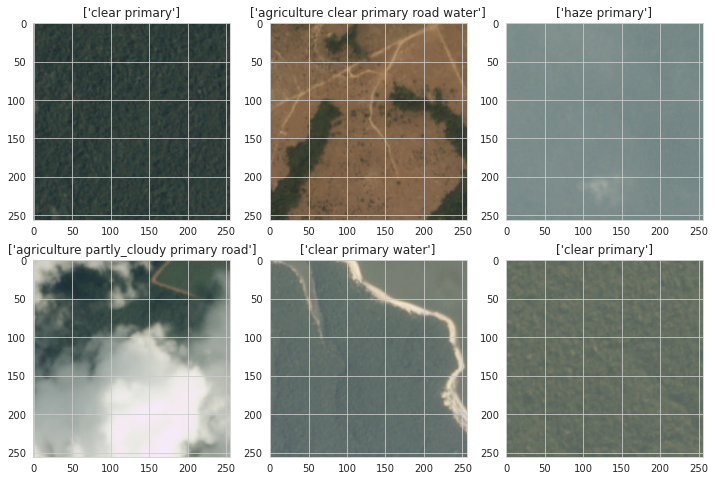

In [ ]:
from glob import glob
image_paths = sorted(glob(train_images_dir + '/*.jpg'))[0:5000]
image_names = list(map(lambda row: row.split("/")[-1][:-4], image_paths))

plt.figure(figsize=(12,8))
for i in range(6):
    num = random.randint(0, len(image_paths))
    plt.subplot(2,3,i+1)
    plt.imshow(plt.imread(image_paths[num]))
    tags = str(df_train[df_train.image_name == image_names[num]].tags.values)
    plt.title(tags)

## Understanding the tags

In [ ]:
def get_tags(df_train):
    return list(chain.from_iterable([tags.split(' ') for tags in df_train['tags'].values]))   

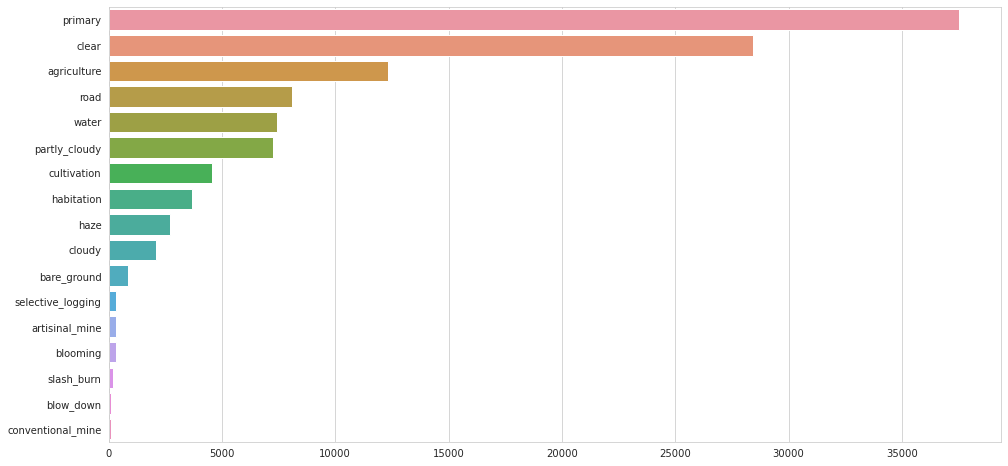

In [ ]:
def plot_tags_histogram(df_train):
    # Histogram of label instances
    tags = get_tags(df_train)
    tags_series = pd.Series(tags).value_counts()
    fig, ax = plt.subplots(figsize=(16, 8))
    sns.barplot(x=tags_series, y=tags_series.index, orient='h')
    # pd.DataFrame(set(labels_list), columns=['labels'])
plot_tags_histogram(df_train)

In [ ]:
# # conver to co-occurance matrix
# co_mat = pd.crosstab(labels_df.labels, labels_df.position)
# # plot heat map of co-occuance matrix
# sns.heatmap(co_mat)

## Prepare dataset

In [ ]:
unique_tags = np.unique(get_tags(df_train))
print(unique_tags)

['agriculture' 'artisinal_mine' 'bare_ground' 'blooming' 'blow_down'
 'clear' 'cloudy' 'conventional_mine' 'cultivation' 'habitation' 'haze'
 'partly_cloudy' 'primary' 'road' 'selective_logging' 'slash_burn' 'water']


In [ ]:
unique_labels = set()
def append_labels(tags):
    for tag in tags.split():
        unique_labels.add(tag)

train_data = df_train.copy()
train_data['tags'].apply(append_labels)

# vectorize the labels into one hot encoded tag
for tag in unique_labels:
    train_data[tag] = train_data['tags'].apply(lambda x: 1 if tag in x.split() else 0)
    
# adding '.jpg' extension to 'image_name'
train_data['image_name'] = train_data['image_name'].apply(lambda x: '{}.jpg'.format(x)) 
train_data.head()

,image_name,tags,habitation,agriculture,selective_logging,artisinal_mine,cloudy,haze,cultivation,partly_cloudy,bare_ground,blow_down,conventional_mine,blooming,primary,clear,water,road,slash_burn
0,train_0.jpg,haze primary,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1,train_1.jpg,agriculture clear primary water,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0
2,train_2.jpg,clear primary,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
3,train_3.jpg,clear primary,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
4,train_4.jpg,agriculture clear habitation primary road,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0


### Initialize training image data generator

In [ ]:
y_col = list(train_data.columns[2:]) # storing the tags column names as a variable

# initializing an image generator with some data augumentation
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

# loading images from dataframe
X = image_gen.flow_from_dataframe(dataframe=train_data, x_col='image_name', y_col=y_col, 
                                  directory='../input/planets-dataset/planet/planet/train-jpg/', 
                                  target_size=(128, 128), class_mode='raw', seed=1, batch_size=128)

Found 40479 validated image filenames.


In [ ]:
train_image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,validation_split=0.2)

# generating 80% training image data
train_gen = train_image_gen.flow_from_dataframe(dataframe=train_data, x_col='image_name', y_col=y_col,
                                                directory='../input/planets-dataset/planet/planet/train-jpg/',
                                                target_size=(128, 128), class_mode='raw', seed=0, batch_size=128,
                                                subset='training')

# generating 20% validation image data
val_gen = train_image_gen.flow_from_dataframe(dataframe=train_data, x_col='image_name', y_col=y_col,
                                              directory='../input/planets-dataset/planet/planet/train-jpg/',
                                              target_size=(128, 128), class_mode='raw', seed=0, batch_size=128, 
                                              subset='validation')

Found 32384 validated image filenames.
Found 8095 validated image filenames.


In [ ]:
# setting step size for training and validation image data
step_train_size = int(np.ceil(train_gen.samples / train_gen.batch_size))
step_val_size = int(np.ceil(val_gen.samples / train_gen.batch_size))

In [ ]:
def load_dataset(df_train, labels, target_size=(128,128)):
    X_train = []
    y_train = []

    label_map = {label: index for index, label in enumerate(labels)}
    # inv_label_map = {i: l for l, i in label_map.items()}

    for fname, tags in df_train.values[:1000]:
        # load image
        img = load_img(f'{train_images_dir}/{fname}.jpg', target_size=target_size)
        # convert to numpy array
        img_array = img_to_array(img, dtype='uint8')
        # create one hot encode tag
        target = np.zeros(len(labels)) # len(labels) == 17
        for tag in tags.split(' '):
            target[label_map[tag]] = 1 

        X_train.append(img_array)
        y_train.append(target)
        
    y_train = np.array(y_train, np.uint8)
    X_train = np.array(X_train, np.float16) / 255.0

    return X_train, y_train


In [ ]:
# target_size = (128, 128)
# all_tags = get_tags(df_train)
# labels = list(set(all_tags))
# X, y = load_dataset(df_train, labels, target_size=target_size)
# print(X.shape, y.shape)
# gc.collect()

## Define metric

In [ ]:
def fbeta_score(y_true, y_pred):
    beta_squared = 4

    tp = keras.backend.sum(y_true * y_pred) + keras.backend.epsilon()
    fp = keras.backend.sum(y_pred) - tp
    fn = keras.backend.sum(y_true) - tp

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    result = (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + keras.backend.epsilon())
    return result

## Learning curve

In [ ]:
def learning_curve(model_fit, key='acc', ylim=(0.8, 1.01)):
    plt.figure(figsize=(12,6))
    plt.plot(model_fit.history[key])
    plt.plot(model_fit.history['val_' + key])
    plt.title('Learning Curve')
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['train', 'test'], loc='best')
    plt.show()

In [ ]:
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state = 2)

### Build CNN

In [ ]:
def build_model():
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.1),

        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.1),

        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.1),

        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(256, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.1),
        
        Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(512, kernel_size=(3, 3), activation='relu'),

        Flatten(),

        Dense(1024, activation='relu'),
        Dense(17, activation='sigmoid') 
    ])
    # optimizer = Adam(0.003, decay=0.0005)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[fbeta_score])
    return model

### Try VGG16

In [ ]:
def build_vgg_model():
    optimizer = Adam(0.003, decay=0.0005)
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential([
        base_model,

        Flatten(), 

        Dense(128, activation='relu'),
    #     Dropout(0.2),
        Dense(17, activation='sigmoid')  
    ])

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[fbeta_score])
    return model

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

def model_summary(model):
    model.summary()
    # from keras.utils import plot_model
    # plot model architecture
    # plot_model(model, show_shapes=True, to_file='cnn_amazon.png')

def fit_model(model, epochs=2):
    checkpoint = ModelCheckpoint("amazon.h5", monitor='val_fbeta_score', verbose=1, 
                                 save_best_only=True, save_weights_only=True, mode='max')
    early = EarlyStopping(monitor='val_fbeta_score', min_delta=0, patience=20, verbose=1, mode='auto')
    history = model.fit(
        x=train_gen,
        steps_per_epoch=step_train_size,
        validation_data=val_gen,
        validation_steps=step_val_size,
        epochs=epochs,
        callbacks=[checkpoint, early]
    )
    return history
    # model_fit = model.fit(
    #     X_train, y_train,
    #     batch_size=64,
    #     epochs=50,
    #     verbose=1,
    #     validation_data=(X_val, y_val),
    #     callbacks=[checkpoint, early]
    # )

In [ ]:
model1 = build_vgg_model()
model_summary(model1)
history = fit_model(model1, epochs=5)

58892288/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1048704   
_________________________________________________________________
dense_1 (Dense)              (None, 17)                2193      
Total params: 15,765,585
Trainable params: 1,050,897
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/5
253/253 [==============================] - ETA: 0s - loss: 0.1704 - fbeta_score: 0.7183
Epoch 00001: val_fbeta_score improved from -inf to 0.75230, saving mode

In [ ]:
# val_gen.reset()
# y_pred = model.predict(val_gen, steps=step_test_size1, verbose=1)
# score = sklearn_fbeta_score(y_val, np.array(y_pred) > 0.2, beta=2, average='samples')

# print("F beta score: ", score)
# print("Error: %.2f%%" % (100 - score * 100))
# model.save("my_amazon_cnn_model.h5")

# from IPython.display import FileLink
# FileLink('amazon.h5')

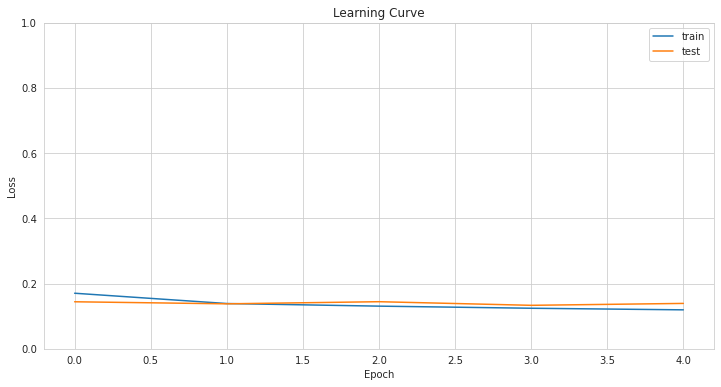

In [ ]:
learning_curve(history, key='loss', ylim=(0, 1))

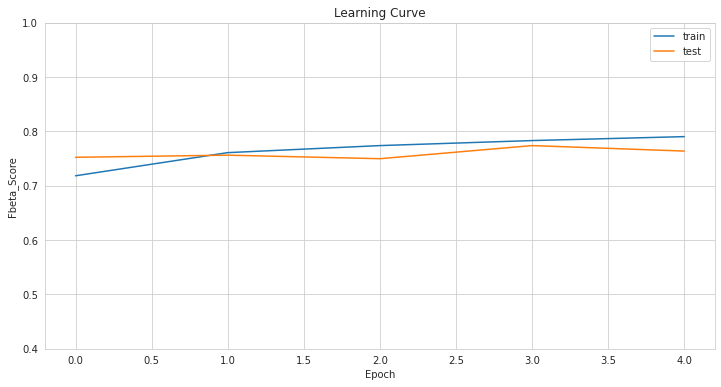

In [ ]:
learning_curve(history, key='fbeta_score', ylim=(0.4, 1))

### Submission

In [ ]:
sample_submission_df = pd.read_csv(sample_submission)
sample_submission = sample_submission_df.copy()
sample_submission['image_name'] = sample_submission['image_name'].apply(lambda x: '{}.jpg'.format(x))
sample_submission.head()

,image_name,tags
0,test_0.jpg,primary clear agriculture road water
1,test_1.jpg,primary clear agriculture road water
2,test_2.jpg,primary clear agriculture road water
3,test_3.jpg,primary clear agriculture road water
4,test_4.jpg,primary clear agriculture road water


### Initialize testing image data generator

In [ ]:
def prepare_testing_result(test_df, test_images_dir, model):
    # initializing an image data generator object
    test_image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

    # generating the image data for the first 40669 images in the sample submission dataframe
    test_gen = test_image_gen.flow_from_dataframe(dataframe=test_df, x_col='image_name', y_col=None,
                                                    directory=test_images_dir,
                                                    batch_size=128, shuffle=False, class_mode=None, target_size=(128, 128))

    # setting the step size for the testing set
    step_test_size = int(np.ceil(test_gen.samples / test_gen.batch_size))

    test_gen.reset() # reseting the generator to avoid shuffling
    tags_pred = model.predict(test_gen, steps=step_test_size, verbose=1)

    image_names = test_gen.filenames # storing the filenames (images names)

    # converting the predictions to tag names
    tags_predicted = pd.DataFrame(tags_pred)
    tags_predicted = tags_predicted.apply(lambda x: ' '.join(unique_tags[x > 0.5]), axis=1)

    # converting the predictions of to a dataframe
    result = pd.DataFrame({'image_name': image_names, 'tags': tags_predicted})
    return result

In [ ]:
test_df = sample_submission.iloc[:40669]['image_name'].reset_index().drop('index', axis=1)
print(test_df.shape)
test_df.head()

(40669, 1)


,image_name
0,test_0.jpg
1,test_1.jpg
2,test_2.jpg
3,test_3.jpg
4,test_4.jpg


In [ ]:
test_result = prepare_testing_result(test_df, test_images_dir, model1)
print(test_result.shape)
test_result.head()

Found 40669 validated image filenames.
318/318 [==============================] - 931s 3s/step
(40669, 2)


,image_name,tags
0,test_0.jpg,primary road
1,test_1.jpg,primary road
2,test_2.jpg,conventional_mine primary
3,test_3.jpg,primary road
4,test_4.jpg,conventional_mine primary


In [ ]:
additional_test_df = sample_submission.iloc[40669:]['image_name'].reset_index().drop('index', axis=1)
print(additional_test_df.shape)
additional_test_df.head()

(20522, 1)


,image_name
0,file_0.jpg
1,file_1.jpg
2,file_10.jpg
3,file_100.jpg
4,file_1000.jpg


In [ ]:
additional_test_result = prepare_testing_result(additional_test_df, test_additional_images_dir, model1)
print(additional_test_result.shape)
additional_test_result.head()

Found 20522 validated image filenames.
161/161 [==============================] - 470s 3s/step
(20522, 2)


,image_name,tags
0,file_0.jpg,primary road
1,file_1.jpg,artisinal_mine conventional_mine primary slash...
2,file_10.jpg,primary selective_logging slash_burn
3,file_100.jpg,primary road selective_logging slash_burn
4,file_1000.jpg,primary road


In [ ]:
final_result_df = pd.concat([test_result, additional_test_result])
final_result_df = final_result_df.reset_index().drop('index', axis=1) 
final_result_df['image_name'] = final_result_df['image_name'].apply(lambda x: x[:-4])

print("Prediction rows:", final_result_df.size, "Shape:", final_result_df.shape) # exp Prediction rows 61191
final_result_df.head()

Prediction rows: 122382 Shape: (61191, 2)


,image_name,tags
0,test_0,primary road
1,test_1,primary road
2,test_2,conventional_mine primary
3,test_3,primary road
4,test_4,conventional_mine primary


In [ ]:
assert final_result_df.shape[0] == 61191

In [ ]:
# final = pd.read_csv('submission_file1.csv')
# final.head()
# final.to_csv('submission_second.csv', index=False)

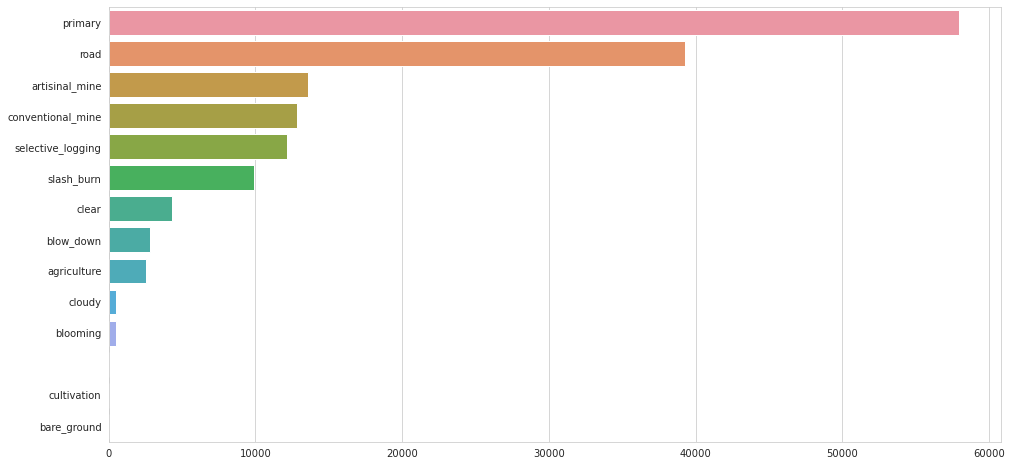

In [ ]:
plot_tags_histogram(final_result_df)
final_result_df.to_csv('submission_file1.csv', index=False)

In [ ]:
final_result_df.to_csv('submission.csv', index=False)

In [ ]:
! ls

amazon.h5
multilabel-classification-of-amazon-conditions-00ef16c9-0f57-4e3a-815f-71dd43316516.ipynb
submission-test-jpg-1.csv
submission-test-jpg-additional-1.csv
submission-test-jpg-additional.csv
submission-test-jpg.csv
submission.csv
submission_1.csv
submission_file1.csv


In [ ]:
! ls -al /root/.kaggle/

total 12
drwxr-xr-x 2 root root 4096 Sep 20 09:27 .
drwx------ 1 root root 4096 Sep 20 08:48 ..
-rw------- 1 root root   63 Sep 20 09:27 kaggle.json


In [ ]:
!kaggle competitions submit -c planet-understanding-the-amazon-from-space -f submission_second.csv -m "Second submission"

100%|███████████████████████████████████████| 2.07M/2.07M [00:03<00:00, 632kB/s]
Successfully submitted to Planet: Understanding the Amazon from Space

In [ ]:
target_size = (128, 128)

def test_prediction(test_images_dir):
    X_test = []
    submission = []
    suffix = test_images_dir.split('/')[-1]
    for file in os.listdir(test_images_dir):
        filename = file.split('.')[0]

        img = load_img(f'{test_images_dir}/{filename}.jpg', target_size=target_size)
        img_array = img_to_array(img, dtype='uint8')
        target = np.zeros(len(unique_tags))

        X_test.append(img_array)
        submission.append(filename)

    X_test = np.array(X_test, np.float16) / 255
    y_test = model1.predict(X_test, batch_size=64)
    
    output_filename = f'submission-{suffix}.csv'
    with open(output_filename, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
        csv_writer.writerow(('image_name', 'tags'))
        for i, image in enumerate(submission):
            csv_writer.writerow((image, ' '.join(np.array(unique_tags)[y_test[i] > 0.5])))
    return output_filename

In [ ]:
output = test_prediction(test_images_dir)

In [ ]:
test1 = pd.read_csv(output)
# final_result_df.to_csv('submission_testfile1.csv', index=False)
test1.head()

In [ ]:
plot_tags_histogram(test1)

In [ ]:
output2 = test_prediction(test_additional_images_dir)
test2 = pd.read_csv(output2)
# final_result_df.to_csv('submission_testfile1.csv', index=False)
test2.head()

In [ ]:
result_df = pd.concat([test1, test2])
result_df = result_df.reset_index().drop('index', axis=1)

print("Prediction rows:", result_df.size, "Shape:", result_df.shape) # exp Prediction rows 61191
final_result_df.head()

In [ ]:
plot_tags_histogram(result_df)

In [ ]:
result_df.to_csv('submission_1.csv', index=False)